# Initial setup and model training

In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set(style="ticks", color_codes=True)
dataset = load_dataset('climate_fever');

Using custom data configuration default
Reusing dataset climate_fever (/Users/ericjiang/.cache/huggingface/datasets/climate_fever/default/1.0.1/3b846b20d7a37bc0019b0f0dcbde5bf2d0f94f6874f7e4c398c579f332c4262c)


In [2]:
df = pd.DataFrame(dataset)

In [3]:
df.head()

test
0  {'claim': 'Global warming is driving polar bea...
1  {'claim': 'The sun has gone into ‘lockdown’ wh...
2  {'claim': 'The polar bear population has been ...
3  {'claim': 'Ironic' study finds more CO2 has sl...
4  {'claim': 'Human additions of CO2 are in the m...

In [4]:
# the structure of each row
df.iloc[0]['test']

{'claim': 'Global warming is driving polar bears toward extinction',
 'claim_id': '0',
 'claim_label': 0,
 'evidences': [{'article': 'Extinction risk from global warming',
   'entropy': 0.6931471824645996,
   'evidence': '"Recent Research Shows Human Activity Driving Earth Towards Global Extinction Event".',
   'evidence_id': 'Extinction risk from global warming:170',
   'evidence_label': 2,
   'votes': ['SUPPORTS', 'NOT_ENOUGH_INFO', None, None, None]},
  {'article': 'Global warming',
   'entropy': 0.0,
   'evidence': 'Environmental impacts include the extinction or relocation of many species as their ecosystems change, most immediately the environments of coral reefs, mountains, and the Arctic.',
   'evidence_id': 'Global warming:14',
   'evidence_label': 0,
   'votes': ['SUPPORTS', 'SUPPORTS', None, None, None]},
  {'article': 'Global warming',
   'entropy': 0.6931471824645996,
   'evidence': 'Rising temperatures push bees to their physiological limits, and could cause the extinctio

In [5]:
# an example to extract relevant text
# 'article' and 'evidence_id' are not included as they provide redundant/same content compared with the 'evidence'
# moreover, they are simple phrases rather than meaningful sentences, which might decrease the performance of the model
print(df.iloc[0]['test']['claim'])
print(df.iloc[0]['test']['evidences'][0]['evidence'])

Global warming is driving polar bears toward extinction
"Recent Research Shows Human Activity Driving Earth Towards Global Extinction Event".


In [6]:
# extract relevant text from each row
result = []
for i in range(len(df)):
    result_sub = []
    result_sub.append(df.iloc[i]['test']['claim'])
    for j in range(5):
        result_sub.append(df.iloc[i]['test']['evidences'][j]['evidence'])
    result.append(result_sub)
df['text'] = result

In [7]:
df.iloc[0]['text']

['Global warming is driving polar bears toward extinction',
 '"Recent Research Shows Human Activity Driving Earth Towards Global Extinction Event".',
 'Environmental impacts include the extinction or relocation of many species as their ecosystems change, most immediately the environments of coral reefs, mountains, and the Arctic.',
 'Rising temperatures push bees to their physiological limits, and could cause the extinction of bee populations.',
 'Rising global temperatures, caused by the greenhouse effect, contribute to habitat destruction, endangering various species, such as the polar bear.',
 '"Bear hunting caught in global warming debate".']

In [8]:
# drop the original column
df = df.drop('test',axis=1)

In [9]:
df.head()

text
0  [Global warming is driving polar bears toward ...
1  [The sun has gone into ‘lockdown’ which could ...
2  [The polar bear population has been growing., ...
3  [Ironic' study finds more CO2 has slightly coo...
4  [Human additions of CO2 are in the margin of e...

In [10]:
# prepare the data for further preprocessing
result = []
for i in range(len(df)):
    result.append(','.join(df.iloc[i]['text']))
df['text_formatted'] = result

In [11]:
df.head()

text  \
0  [Global warming is driving polar bears toward ...   
1  [The sun has gone into ‘lockdown’ which could ...   
2  [The polar bear population has been growing., ...   
3  [Ironic' study finds more CO2 has slightly coo...   
4  [Human additions of CO2 are in the margin of e...   

                                      text_formatted  
0  Global warming is driving polar bears toward e...  
1  The sun has gone into ‘lockdown’ which could c...  
2  The polar bear population has been growing.,"A...  
3  Ironic' study finds more CO2 has slightly cool...  
4  Human additions of CO2 are in the margin of er...

In [12]:
# drop the unformatted text column
df = df.drop('text',axis=1)

In [13]:
df.iloc[0]['text_formatted']

'Global warming is driving polar bears toward extinction,"Recent Research Shows Human Activity Driving Earth Towards Global Extinction Event".,Environmental impacts include the extinction or relocation of many species as their ecosystems change, most immediately the environments of coral reefs, mountains, and the Arctic.,Rising temperatures push bees to their physiological limits, and could cause the extinction of bee populations.,Rising global temperatures, caused by the greenhouse effect, contribute to habitat destruction, endangering various species, such as the polar bear.,"Bear hunting caught in global warming debate".'

In [14]:
# remove punctuations and so on
import re

def simple_tokenize(s):
    return re.findall(r"[a-z]+(?:'[a-z]+)?",s.lower())

In [15]:
for i in range(len(df)):
    df['text_formatted'][i] = simple_tokenize(df['text_formatted'][i])

In [16]:
df.head(10)

text_formatted
0  [global, warming, is, driving, polar, bears, t...
1  [the, sun, has, gone, into, lockdown, which, c...
2  [the, polar, bear, population, has, been, grow...
3  [ironic, study, finds, more, co, has, slightly...
4  [human, additions, of, co, are, in, the, margi...
5  [they, tell, us, that, we, are, the, primary, ...
6  [the, great, barrier, reef, is, experiencing, ...
7  [it, s, not, a, pollutant, that, threatens, hu...
8  [if, co, was, so, terrible, for, the, planet, ...
9  [sea, level, rise, has, been, slow, and, a, co...

In [17]:
# remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
en_stops = set(stopwords.words('english'))
stops = en_stops
stops = list(stops)
sen_list_new=[]
for i in range(len(df)):
    t = []
    for j in range(len(df['text_formatted'][i])):
        if df['text_formatted'][i][j] not in stops:
            t.append(df['text_formatted'][i][j])
    df['text_formatted'][i] = t

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ericjiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
df.head(10)

text_formatted
0  [global, warming, driving, polar, bears, towar...
1  [sun, gone, lockdown, could, cause, freezing, ...
2  [polar, bear, population, growing, ask, expert...
3  [ironic, study, finds, co, slightly, cooled, p...
4  [human, additions, co, margin, error, current,...
5  [tell, us, primary, forces, controlling, earth...
6  [great, barrier, reef, experiencing, widesprea...
7  [pollutant, threatens, human, civilization, ai...
8  [co, terrible, planet, installing, co, generat...
9  [sea, level, rise, slow, constant, pre, dating...

In [19]:
# stemming
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
result = []
for i in range(len(df)):
    sub_result = []
    for w in df.iloc[i]['text_formatted']:
        sub_result.append(lemmatizer.lemmatize(w))
    result.append(sub_result)
df['text_formatted'] = result

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ericjiang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
df.head(10)

text_formatted
0  [global, warming, driving, polar, bear, toward...
1  [sun, gone, lockdown, could, cause, freezing, ...
2  [polar, bear, population, growing, ask, expert...
3  [ironic, study, find, co, slightly, cooled, pl...
4  [human, addition, co, margin, error, current, ...
5  [tell, u, primary, force, controlling, earth, ...
6  [great, barrier, reef, experiencing, widesprea...
7  [pollutant, threatens, human, civilization, ai...
8  [co, terrible, planet, installing, co, generat...
9  [sea, level, rise, slow, constant, pre, dating...

In [21]:
# train-test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=0)
train = train.reset_index().drop('index',axis=1)
test = test.reset_index().drop('index',axis=1)

In [22]:
# format the whole dataset, train set, test set for model implementation
sentence = []
for i in range(len(df)):
    sentence.append(df.iloc[i]['text_formatted'])

train_sentence = []
for i in range(len(train)):
    train_sentence.append(train.iloc[i]['text_formatted'])

test_sentence = []
for i in range(len(test)):
    test_sentence.append(test.iloc[i]['text_formatted'])

In [23]:
sentence[:1]

[['global',
  'warming',
  'driving',
  'polar',
  'bear',
  'toward',
  'extinction',
  'recent',
  'research',
  'show',
  'human',
  'activity',
  'driving',
  'earth',
  'towards',
  'global',
  'extinction',
  'event',
  'environmental',
  'impact',
  'include',
  'extinction',
  'relocation',
  'many',
  'specie',
  'ecosystem',
  'change',
  'immediately',
  'environment',
  'coral',
  'reef',
  'mountain',
  'arctic',
  'rising',
  'temperature',
  'push',
  'bee',
  'physiological',
  'limit',
  'could',
  'cause',
  'extinction',
  'bee',
  'population',
  'rising',
  'global',
  'temperature',
  'caused',
  'greenhouse',
  'effect',
  'contribute',
  'habitat',
  'destruction',
  'endangering',
  'various',
  'specie',
  'polar',
  'bear',
  'bear',
  'hunting',
  'caught',
  'global',
  'warming',
  'debate']]

In [24]:
# implement the word2vec model
# use the whole dataset, and choose the skip-gram method as it is more common in practice
import gensim
from gensim.models import Word2Vec
model = Word2Vec(sentences=sentence,min_count=1,sg=1)

In [25]:
print(model)

Word2Vec(vocab=10120, size=100, alpha=0.025)


In [26]:
# all vocabularies in the trained model
vocab = list(model.wv.vocab)
vocab[:20]

['global',
 'warming',
 'driving',
 'polar',
 'bear',
 'toward',
 'extinction',
 'recent',
 'research',
 'show',
 'human',
 'activity',
 'earth',
 'towards',
 'event',
 'environmental',
 'impact',
 'include',
 'relocation',
 'many']

In [27]:
# example to get word embeddings
print(model.wv['global'])
print(model.wv['hurricane'])

[ 0.20671797  0.37621933  0.22720225 -0.27140328 -0.27384365 -0.0181783
 -0.34435633 -0.38765442 -0.10910575  0.21339017  0.04021433  0.17996849
 -0.14273341 -0.32788253 -0.23522069 -0.14390951 -0.04914973  0.48467362
  0.3405603  -0.15610568  0.37518683  0.17618063  0.28824258  0.00249635
 -0.5701668   0.29991162  0.01393501 -0.14349763 -0.25479543 -0.18687093
 -0.132751    0.29354182 -0.09570598  0.41122907 -0.11448336  0.00643491
 -0.26681802  0.03205444 -0.16302729  0.43773806 -0.2676292  -0.01727389
 -0.03906703  0.5099819   0.12719275  0.02704866  0.08181828 -0.00337082
 -0.1724985   0.7528183  -0.44936374  0.4538122  -0.05903605 -0.26770788
  0.1477496   0.37201628  0.39899457 -0.02569776  0.45039353 -0.00473775
  0.36710432  0.09252965  0.20621158  0.7863132   0.14007577  0.15084107
  0.23561391 -0.28370774  0.12069394  0.02664121 -0.59652036 -0.7930713
 -0.2632362   0.41132203  0.35779232  0.2584576   0.3946367   0.12954733
 -0.62126493  0.08938938  0.2966247  -0.0042991   0.4

# Cosine similarity

In [29]:
# define a function to flatten a nested list
def flatten(x):
    result = []
    for el in x:
        if hasattr(el, "__iter__") and not isinstance(el, str):
            result.extend(flatten(el))
        else:
            result.append(el)
    return result

In [30]:
# extract the vocabulary in the training set
# (for the whole dataset, it is model.wv.vocab, which is 'vocab' defined in part 1 above)
train_vocab_list = list(flatten(train_sentence))
train_vocab = []
for word in train_vocab_list:
    if word not in train_vocab:
        train_vocab.append(word)

In [31]:
# extract the vocabulary in the test set
# (for the whole dataset, it is model.wv.vocab, which is 'vocab' defined in part 1 above)
test_vocab_list = list(flatten(test_sentence))
test_vocab = []
for word in test_vocab_list:
    if word not in test_vocab:
        test_vocab.append(word)

In [32]:
# function to calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
def get_cosine_similarity(feature_vec_1, feature_vec_2):    
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

**First, we use the whole test word2vec embedding to do the k-means clustering, and look at the cosine similarity within and between clusters. (k-means clustering, as an unsupervised machine learning algorithm, is a good way to find words in similar contexts. And the intention is that word embeddings in the same cluster should have higher cosine similarity than those in different clusters.)**

In [52]:
df = pd.DataFrame(model.wv[test_vocab])
df['word'] = test_vocab
df

0         1         2         3         4         5         6  \
0     0.007856 -0.058123 -0.014765 -0.007591 -0.023257 -0.051739  0.013568   
1    -0.054812 -0.012669  0.076155 -0.074836 -0.069207 -0.245736 -0.276670   
2     0.009712 -0.056185 -0.001890 -0.014627 -0.026659 -0.065764  0.019300   
3     0.137966 -0.146171  0.268179  0.036085  0.008394 -0.420330 -0.426472   
4    -0.013185 -0.180818 -0.010947 -0.046041 -0.070388 -0.225089  0.007513   
...        ...       ...       ...       ...       ...       ...       ...   
4567  0.018920 -0.096142 -0.012324 -0.009958 -0.047197 -0.086628  0.045196   
4568  0.003576 -0.077810 -0.010428 -0.012368 -0.041812 -0.074602  0.038839   
4569  0.010772 -0.079727  0.001814 -0.011091 -0.035222 -0.083332  0.031320   
4570  0.034671 -0.223905  0.032946 -0.049505 -0.130058 -0.231014  0.134048   
4571 -0.005694 -0.143373 -0.001057 -0.045312 -0.081632 -0.141553  0.063697   

             7         8         9  ...        91        92        93  \
0    -0.007313  0.055457  0.032702  ... -0.015734  0.032823  0.033417   
1    -0.005058  0.209724  0.143237  ...  0.106248  0.281772  0.146500   
2    -0.004145  0.080350  0.028035  ... -0.044362  0.042099  0.036515   
3     0.013191  0.203221  0.130695  ...  0.052673  0.433370  0.170788   
4    -0.090092  0.200914  0.121878  ... -0.129523  0.160413  0.136965   
...        ...       ...       ...  ...       ...       ...       ...   
4567 -0.016445  0.095710  0.036422  ... -0.054619  0.048404  0.059583   
4568 -0.005967  0.080746  0.031842  ... -0.048031  0.049215  0.040098   
4569 -0.014067  0.074349  0.023396  ... -0.069938  0.054936  0.044868   
4570 -0.105331  0.193855  0.069527  ... -0.186740  0.132232  0.144768   
4571 -0.050271  0.120417  0.035061  ... -0.127340  0.088826  0.068266   

            94        95        96        97        98        99  \
0     0.003291  0.018520  0.051476 -0.028820  0.067819 -0.052171   
1     0.087789 -0.011436  0.222322 -0.175433  0.250479 -0.397733   
2    -0.014622  0.027604  0.082811 -0.047645  0.101447 -0.067944   
3     0.040807  0.078177  0.486224 -0.286892  0.447193 -0.273550   
4     0.003119  0.110916  0.274154 -0.131734  0.368548 -0.271790   
...        ...       ...       ...       ...       ...       ...   
4567 -0.023786  0.036903  0.087954 -0.055491  0.106328 -0.064136   
4568 -0.018091  0.026496  0.074126 -0.042459  0.092309 -0.060518   
4569 -0.041865  0.036726  0.101790 -0.043686  0.117870 -0.069404   
4570 -0.111811  0.097360  0.270266 -0.114243  0.326180 -0.225293   
4571 -0.070499  0.076846  0.172917 -0.065964  0.214376 -0.127879   

               word  
0       trenberth's  
1              view  
2         clarified  
3             paper  
4        imperative  
...             ...  
4567        wishing  
4568        river's  
4569   deteriorated  
4570  mediterranean  
4571      monsoonal  

[4572 rows x 101 columns]

In [53]:
df_clustering = df.drop('word',axis=1)

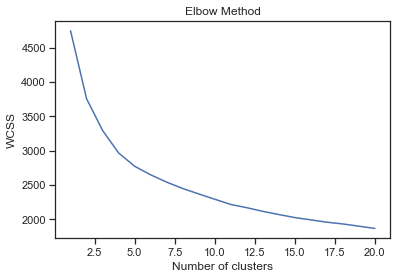

In [54]:
from sklearn.cluster import KMeans 
from scipy.spatial import distance

wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='random', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_clustering)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [55]:
kmeans = KMeans(n_clusters=5, init='random', max_iter=300, n_init=10, random_state=0)
kmeans.fit(df_clustering)

KMeans(init='random', n_clusters=5, random_state=0)

In [56]:
df['label'] = kmeans.labels_
df

0         1         2         3         4         5         6  \
0     0.007856 -0.058123 -0.014765 -0.007591 -0.023257 -0.051739  0.013568   
1    -0.054812 -0.012669  0.076155 -0.074836 -0.069207 -0.245736 -0.276670   
2     0.009712 -0.056185 -0.001890 -0.014627 -0.026659 -0.065764  0.019300   
3     0.137966 -0.146171  0.268179  0.036085  0.008394 -0.420330 -0.426472   
4    -0.013185 -0.180818 -0.010947 -0.046041 -0.070388 -0.225089  0.007513   
...        ...       ...       ...       ...       ...       ...       ...   
4567  0.018920 -0.096142 -0.012324 -0.009958 -0.047197 -0.086628  0.045196   
4568  0.003576 -0.077810 -0.010428 -0.012368 -0.041812 -0.074602  0.038839   
4569  0.010772 -0.079727  0.001814 -0.011091 -0.035222 -0.083332  0.031320   
4570  0.034671 -0.223905  0.032946 -0.049505 -0.130058 -0.231014  0.134048   
4571 -0.005694 -0.143373 -0.001057 -0.045312 -0.081632 -0.141553  0.063697   

             7         8         9  ...        92        93        94  \
0    -0.007313  0.055457  0.032702  ...  0.032823  0.033417  0.003291   
1    -0.005058  0.209724  0.143237  ...  0.281772  0.146500  0.087789   
2    -0.004145  0.080350  0.028035  ...  0.042099  0.036515 -0.014622   
3     0.013191  0.203221  0.130695  ...  0.433370  0.170788  0.040807   
4    -0.090092  0.200914  0.121878  ...  0.160413  0.136965  0.003119   
...        ...       ...       ...  ...       ...       ...       ...   
4567 -0.016445  0.095710  0.036422  ...  0.048404  0.059583 -0.023786   
4568 -0.005967  0.080746  0.031842  ...  0.049215  0.040098 -0.018091   
4569 -0.014067  0.074349  0.023396  ...  0.054936  0.044868 -0.041865   
4570 -0.105331  0.193855  0.069527  ...  0.132232  0.144768 -0.111811   
4571 -0.050271  0.120417  0.035061  ...  0.088826  0.068266 -0.070499   

            95        96        97        98        99           word  label  
0     0.018520  0.051476 -0.028820  0.067819 -0.052171    trenberth's      4  
1    -0.011436  0.222322 -0.175433  0.250479 -0.397733           view      3  
2     0.027604  0.082811 -0.047645  0.101447 -0.067944      clarified      4  
3     0.078177  0.486224 -0.286892  0.447193 -0.273550          paper      3  
4     0.110916  0.274154 -0.131734  0.368548 -0.271790     imperative      2  
...        ...       ...       ...       ...       ...            ...    ...  
4567  0.036903  0.087954 -0.055491  0.106328 -0.064136        wishing      4  
4568  0.026496  0.074126 -0.042459  0.092309 -0.060518        river's      4  
4569  0.036726  0.101790 -0.043686  0.117870 -0.069404   deteriorated      4  
4570  0.097360  0.270266 -0.114243  0.326180 -0.225293  mediterranean      2  
4571  0.076846  0.172917 -0.065964  0.214376 -0.127879      monsoonal      4  

[4572 rows x 102 columns]

In [57]:
df.groupby('label').count()

0     1     2     3     4     5     6     7     8     9  ...    91  \
label                                                              ...         
0       378   378   378   378   378   378   378   378   378   378  ...   378   
1       505   505   505   505   505   505   505   505   505   505  ...   505   
2      1940  1940  1940  1940  1940  1940  1940  1940  1940  1940  ...  1940   
3       376   376   376   376   376   376   376   376   376   376  ...   376   
4      1373  1373  1373  1373  1373  1373  1373  1373  1373  1373  ...  1373   

         92    93    94    95    96    97    98    99  word  
label                                                        
0       378   378   378   378   378   378   378   378   378  
1       505   505   505   505   505   505   505   505   505  
2      1940  1940  1940  1940  1940  1940  1940  1940  1940  
3       376   376   376   376   376   376   376   376   376  
4      1373  1373  1373  1373  1373  1373  1373  1373  1373  

[5 rows x 101 columns]

In [58]:
df_sample = df.sample(n = 1000)

for k in [0,1,2,3,4]:
    df_sub = df_sample[df_sample['label']==k].reset_index().drop('index',axis=1)
    similarity_score_list = []
    for i in range(len(df_sub)):
        word_1 = df_sub.iloc[i]['word']
        for j in range(i+1,len(df_sub)):
            word_2 = df_sub.iloc[j]['word']
            similarity_score_list.append(get_cosine_similarity(model.wv[word_1],model.wv[word_2]))
    similarity_mean = np.mean(similarity_score_list)
    print('in cluster'+' '+str(k)+', the average cosline similarity is'+' '+str(similarity_mean))

in cluster 0, the average cosline similarity is 0.76596004
in cluster 1, the average cosline similarity is 0.760752
in cluster 2, the average cosline similarity is 0.90005434
in cluster 3, the average cosline similarity is 0.80993086
in cluster 4, the average cosline similarity is 0.9641721


In [116]:
# due to the limitation of computational power, only compare cluster 1 and 2 as a between cluster case

df_1 = df[df['label']==1].sample(n = 200).reset_index().drop('index',axis=1)
df_2 = df[df['label']==2].sample(n = 200).reset_index().drop('index',axis=1)

similarity_score_list = []
for i in range(len(df_1)):
    word_1 = df_1.iloc[i]['word']
    for j in range(len(df_2)):
        word_2 = df_2.iloc[j]['word']
        similarity_score_list.append(get_cosine_similarity(model.wv[word_1],model.wv[word_2]))
similarity_mean = np.mean(similarity_score_list)
print('the average cosline similarity between cluster 1 and cluster 2 is'+' '+str(similarity_mean))

the average cosline similarity between cluster 1 and cluster 2 is 0.7255705


**We clustered them into 5 clusters based on Elbow method. As can be seen from the above, the best cosine similarity within clusters is 0.96 observed in cluster 4. However, when we compare word embeddings between clusters, the similarity is 0.73, which is much lower than 0.96. This is in accordance with our initial assumption, as words in one cluster are in similar contexts, leading to higher similarity score.**

**Next, we selected some specific words to do pairwise comparison. Note that these pairwise words are consistent in the reamaining part of this assignment.**
**To implement this, we need to first check whether the words are in our test vocabulary. And the functions to do the check are attached below.**

In [32]:
# function to check whether the words are in the training set
def check_train_validity(word_list):
    a = 1
    for word in word_list:
        if word in train_vocab:
            a = a*1
        else:
            a = a*0
    if a==1:
        return True
    elif a==0:
        return False

In [33]:
# function to check whether the words are in the test set
def check_test_validity(word_list):
    a = 1
    for word in word_list:
        if word in test_vocab:
            a = a*1
        else:
            a = a*0
    if a==1:
        return True
    elif a==0:
        return False

In [34]:
check_test_validity(['hurricane','typhoon'])

True

In [35]:
get_cosine_similarity(model.wv['hurricane'],model.wv['typhoon'])

0.84079087

In [36]:
check_test_validity(['water','ocean'])

True

In [37]:
get_cosine_similarity(model.wv['water'],model.wv['ocean'])

0.77033436

In [38]:
check_test_validity(['warming','temperature'])

True

In [39]:
get_cosine_similarity(model.wv['warming'],model.wv['temperature'])

0.73034155

In [40]:
check_test_validity(['water','land'])

True

In [41]:
get_cosine_similarity(model.wv['water'],model.wv['land'])

0.57134676

**For the above 4 pairs of words, we focus on nouns. As can be seen, words in similar meanings or in similar contexts have higher cosine similarity scores. For words that are not much related, the score is lower. For example, hurricane and typhoon are quite similar and the score is above 0.80. However, water and land are two different domains, and the score is just above 0.50.**

In [42]:
check_test_validity(['decrease','drop'])

True

In [43]:
get_cosine_similarity(model.wv['decrease'],model.wv['drop'])

0.8866238

In [44]:
check_test_validity(['increase','decrease'])

True

In [45]:
get_cosine_similarity(model.wv['increase'],model.wv['decrease'])

0.8641893

In [46]:
check_test_validity(['better','worse'])

True

In [47]:
get_cosine_similarity(model.wv['better'],model.wv['worse'])

0.8468363

In [48]:
check_test_validity(['global','environment'])

True

In [49]:
get_cosine_similarity(model.wv['global'],model.wv['environment'])

0.5201876

In [50]:
check_test_validity(['increase','environment'])

True

In [51]:
get_cosine_similarity(model.wv['increase'],model.wv['environment'])

0.5094454

In [202]:
check_test_validity(['scientist','research'])

True

In [203]:
get_cosine_similarity(model.wv['scientist'],model.wv['research'])

0.84516025

**For here, we analyze further on other word types. For verbs, decrease and drop are quite similar, and thus have a high cosine similarity score. For opposites such as increase and decrease, the score is high as well - One possible explanation is that similarity score measures the similary in word context, not the exact meaning. For instance, increase and decrease are both verbs, and both represent the direction of the number/degree. In this sense, they are similar for sure. This explanation is further proved by getting the similarity score of two adjectives - better and worse.\
However, for words in differnet types/contexts, the similarity score is low. For example, there is not strong connection between increase and environment, thus the score is low.**

# Arithmetic relationships

In [60]:
model.most_similar(positive=['fossil','fuel','burning'])

/Library/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('deforestation', 0.9745142459869385),
 ('broad', 0.960027813911438),
 ('combustion', 0.9453138113021851),
 ('use', 0.9452755451202393),
 ('agriculture', 0.9292916655540466),
 ('biofuel', 0.9163362979888916),
 ('clearing', 0.9139894247055054),
 ('continuing', 0.913097620010376),
 ('particularly', 0.9118615388870239),
 ('primarily', 0.9115666151046753)]

**equation: fossil+fuel+buring=deforestation\
explanation: Burning fossil fuel causes SO2, which will result in acid rain and finally lead to deforestation.**

In [61]:
model.most_similar(positive=['land'], negative=['tree'])

/Library/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('deforestation', 0.44395631551742554),
 ('burning', 0.4391855001449585),
 ('use', 0.4235726296901703),
 ('clearing', 0.42202723026275635),
 ('contribution', 0.41835519671440125),
 ('secondarily', 0.41502583026885986),
 ('aerosol', 0.4143328070640564),
 ('thermal', 0.412788450717926),
 ('methane', 0.4117826819419861),
 ('contributes', 0.4062952995300293)]

**equation: land-tree=deforestation\
explanation: Land without trees leads to deforestation.**

In [62]:
model.most_similar(positive=['snowfall'], negative=['rain'])

/Library/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('greenland', 0.5096641182899475),
 ('glacier', 0.5027742385864258),
 ('antarctic', 0.4950881004333496),
 ('sheet', 0.4857032299041748),
 ('antarctica', 0.48011916875839233),
 ('ice', 0.4463162422180176),
 ('retreat', 0.4368458092212677),
 ('shrinking', 0.43306106328964233),
 ('losing', 0.42416912317276),
 ('accelerating', 0.42010918259620667)]

**equation: snowfall-rain=greenland/glacier/antarctic\
explanation: Snowfall without rain speeds up the formation of glacier. Greenland/antarctic are places where there is a lot of snowfall with little rain.**

In [63]:
model.most_similar(positive=['glacier','warming'])

/Library/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('contributed', 0.9225959777832031),
 ('shrinkage', 0.920630693435669),
 ('greatest', 0.9141349196434021),
 ('retreat', 0.9103876948356628),
 ('shrinking', 0.9023324251174927),
 ('collapse', 0.8989018797874451),
 ('sheet', 0.8937796354293823),
 ('amplification', 0.8919324278831482),
 ('rapid', 0.8917350769042969),
 ('alone', 0.8902977108955383)]

**equation: glacier+warming=shrinkage\
explanation: Global warming leads to the shrinkage of glaciers.**

In [64]:
model.most_similar(positive=['plant','precipitation','fertilization'],negative=['sunlight'])

/Library/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('died', 0.9322299957275391),
 ('death', 0.923570454120636),
 ('houston', 0.9152711629867554),
 ('flowering', 0.9145472645759583),
 ('damaged', 0.9120389223098755),
 ('prevalence', 0.9120382070541382),
 ("pattern's", 0.9110398292541504),
 ('heaviest', 0.9099853038787842),
 ('heavier', 0.9098594188690186),
 ('typhoon', 0.9092879295349121)]

**equation: plant+precipitation+fertilization-sunlight=death\
explanation: Giving plant water and fertilizer but no sunslight will cause it to die.**

In [65]:
model.most_similar(positive=['precipitation','fertilization'])

/Library/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('flowering', 0.9874893426895142),
 ('heaviest', 0.9808551073074341),
 ('accompanied', 0.9795868396759033),
 ('regime', 0.9782183170318604),
 ("pattern's", 0.9729052782058716),
 ('freak', 0.9719641208648682),
 ('vanishing', 0.9717278480529785),
 ('spread', 0.9714702367782593),
 ('typhoon', 0.9696393013000488),
 ('poleward', 0.9689178466796875)]

**equation: precipitation+fertilization=flowering\
explanation: Precipitation and fertilization speeds up the flowering of plants.**

# Comparison of two pre-trained models

**We couldn't find a pretrained glove and word2vec model on the same dataset. That means we used the climate fever dataset but we couldn't find it's pretrained glove model anywhere. Also based on the question we could find the glove-wiki-gigaword-50, but there isn't any word2vec-wiki-gigaword-50 in gensim, so we decided to compare the result of glove-wiki-gigaword-50 with word2vec-google-news-300 and our trained word2vec model on the ClimateFever dataset based on the same words existing in all three models.**

In [139]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


**Comparison between word2vec and glove at a high level:\
The two models differ in the way they are trained, and hence lead to word vectors with subtly different properties. Glove model is based on leveraging global word to word co-occurance counts leveraging the entire corpus. Word2vec on the other hand leverages co-occurance within local context (neighbouring words).\
In practice, however, both these models give similar results for many tasks. Factors such as the dataset on which these models are trained, length of the vectors and so on seem to have a bigger impact than the models themselves.\
The glove algorithm can sometimes find the nearest neighbors (words) that lie outside an average human's vocabulary, resulting in finding words with higher similarity scores.**

In [199]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50');

In [141]:
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300');

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [142]:
glove_vectors.most_similar(positive=['fossil','fuel','burning'])

[('gas', 0.8042939305305481),
 ('fuels', 0.7761564254760742),
 ('coal', 0.7638977766036987),
 ('carbon', 0.7560535073280334),
 ('waste', 0.7483071684837341),
 ('gasoline', 0.7442378997802734),
 ('water', 0.7412325143814087),
 ('gases', 0.7344748973846436),
 ('natural', 0.7193182110786438),
 ('methane', 0.7183080911636353)]

In [205]:
word2vec_vectors.most_similar(positive=['fossil','fuel','burning'])

[('fuels', 0.5923791527748108),
 ('fossil_fuel', 0.5840647220611572),
 ('gasoline', 0.5804163217544556),
 ('diesel', 0.5615079402923584),
 ('fossil_fuels', 0.5538089871406555),
 ('diesel_fuel', 0.5535875558853149),
 ('forest_thinnings', 0.5491923093795776),
 ('----------------------------------------------------------_motor',
  0.5418771505355835),
 ('biodiesel_fuels', 0.5418532490730286),
 ('dirtiest_fossil', 0.5380221605300903)]

In [206]:
glove_vectors.most_similar(positive=['land'], negative=['tree'])

[('territory', 0.6321002244949341),
 ('territories', 0.6103670597076416),
 ('overflight', 0.5773293972015381),
 ('retaken', 0.565340518951416),
 ('non-indians', 0.565321683883667),
 ('ceded', 0.5644488334655762),
 ('sovereignty', 0.5615805387496948),
 ('protectorate', 0.5615330934524536),
 ('overflights', 0.557738184928894),
 ('granted', 0.5559909343719482)]

In [207]:
word2vec_vectors.most_similar(positive=['land'], negative=['tree'])

[('lands', 0.4758806824684143),
 ('farmland', 0.39269351959228516),
 ('undeveloped_land', 0.3897038400173187),
 ('Land', 0.366924524307251),
 ('vast_tracts', 0.3600132465362549),
 ('Shaul_Arlosoroff_leading', 0.35607513785362244),
 ('acre_parcel', 0.3462804853916168),
 ('Yamuna_expressway', 0.3448556065559387),
 ('lakh_kanals', 0.34251320362091064),
 ('minister_Abdur_Rezzak', 0.34160923957824707)]

In [208]:
glove_vectors.most_similar(positive=['snowfall'], negative=['rain'])

[('783,000', 0.7106807827949524),
 ('8.5-percent', 0.6843075752258301),
 ('meistaradeildin', 0.6694743633270264),
 ('time-period', 0.649803638458252),
 ('seventh-highest', 0.6470305919647217),
 ('periodicity', 0.6446992754936218),
 ('five-fold', 0.6359882354736328),
 ('südliche', 0.6337831020355225),
 ('benkler', 0.6324289441108704),
 ('25-fold', 0.6284388303756714)]

In [209]:
word2vec_vectors.most_similar(positive=['snowfall'], negative=['rain'])

[('snowfalls', 0.39991623163223267),
 ('snowiest', 0.38648557662963867),
 ('snowiest_winter', 0.38292863965034485),
 ('snowfall_totals', 0.35687077045440674),
 ('snowstorms', 0.34144335985183716),
 ('Breckenridge_Ski_Resort', 0.3403792381286621),
 ('skier_visits', 0.33333897590637207),
 ('ski_resorts', 0.33202219009399414),
 ('Arapahoe_Basin', 0.32822635769844055),
 ('snow_removal', 0.3248952329158783)]

In [210]:
glove_vectors.most_similar(positive=['glacier','warming'])

[('arctic', 0.7848324775695801),
 ('glaciers', 0.7784826159477234),
 ('antarctica', 0.7756611108779907),
 ('oceans', 0.7334003448486328),
 ('melting', 0.7301900386810303),
 ('flows', 0.7111421823501587),
 ('polar', 0.6838343143463135),
 ('slope', 0.6759179830551147),
 ('climate', 0.6723143458366394),
 ('permafrost', 0.669768750667572)]

In [211]:
word2vec_vectors.most_similar(positive=['glacier','warming'])

[('glaciers', 0.7227829694747925),
 ('glacial_melting', 0.683213472366333),
 ('glacial_melt', 0.6592143774032593),
 ('glaciers_melting', 0.6266379952430725),
 ('glacial_retreat', 0.6200346350669861),
 ('Greenland_ice', 0.6189225912094116),
 ('polar_ice', 0.614848792552948),
 ('melting', 0.6138577461242676),
 ('receding_glaciers', 0.611780047416687),
 ('mountain_glaciers', 0.609243631362915)]

In [212]:
glove_vectors.most_similar(positive=['plant','precipitation','fertilization'],negative=['sunlight'])

[('dairy', 0.6634349822998047),
 ('plants', 0.6429395079612732),
 ('occurring', 0.6410154104232788),
 ('poultry', 0.6409883499145508),
 ('farming', 0.6341347694396973),
 ('breeding', 0.6304994821548462),
 ('farms', 0.6263927221298218),
 ('disease', 0.6223506331443787),
 ('harvesting', 0.6222288012504578),
 ('occurs', 0.6181702613830566)]

In [213]:
word2vec_vectors.most_similar(positive=['plant','precipitation','fertilization'],negative=['sunlight'])

[('rainfall', 0.51261305809021),
 ('vegetative_propagation', 0.5098195672035217),
 ('plants', 0.5024074912071228),
 ('stem_elongation', 0.4933736026287079),
 ('glyphosate_resistant_horseweed', 0.4880848824977875),
 ('triploid', 0.4865646958351135),
 ('Plant', 0.4863937497138977),
 ('seedbank', 0.485634982585907),
 ('sugar_beet_crop', 0.4841872751712799),
 ('MMgy_plant', 0.4807637333869934)]

In [214]:
glove_vectors.most_similar(positive=['precipitation','fertilization'])

[('evaporation', 0.8046144843101501),
 ('temperature', 0.7356302738189697),
 ('melting', 0.7193467617034912),
 ('respiration', 0.711851954460144),
 ('occurs', 0.6953213214874268),
 ('rainfall', 0.6827709674835205),
 ('vaginal', 0.6757187843322754),
 ('hypoxia', 0.6649883985519409),
 ('seawater', 0.6647964715957642),
 ('decreases', 0.659529983997345)]

In [215]:
word2vec_vectors.most_similar(positive=['precipitation','fertilization'])

[('rainfall', 0.7249063849449158),
 ('Precipitation', 0.6411056518554688),
 ('precip', 0.6127467155456543),
 ('Rainfall', 0.6012617945671082),
 ('rainfalls', 0.6004058718681335),
 ('soil_moisture', 0.5911860466003418),
 ('fertilizing', 0.5906873941421509),
 ('nitrogen_fertilization', 0.589134156703949),
 ('drier_soils', 0.5842441320419312),
 ('germination', 0.579255223274231)]

**The glove model does much better compared with pre-trained word2vec in finding the most similar words, but is worse than our word2vec model with the climate fever dataset.\
Besieds, for words suggested by both pre-trained models, semantically those pairs of words have higher similarity in glove than word2vec. For example, 'fuels' in the glove model has a similarity score of 0.77 with [fossil,fuel,burning]. However, the score is much lower (0.59) in the word2vec pre-trained model on google news.**

# PCA

In [33]:
#Creating Word2Vec embedding of train set 
train_embed = model.wv[train_vocab]

In [34]:
#Apply PCA to train_embed
from sklearn.decomposition import PCA
pca = PCA()
pca_results = pca.fit_transform(train_embed)

In [35]:
pca_results

array([[ 9.8271412e-01, -9.1644573e-01, -8.9586619e-03, ...,
         1.9122646e-03, -7.2726123e-03, -4.5415885e-03],
       [ 1.7594812e+00, -1.0403743e+00,  2.6978835e-02, ...,
        -8.4110033e-03, -5.1973131e-03,  1.0384339e-02],
       [ 2.6226810e-01, -2.6666570e-01,  2.7787881e-02, ...,
         2.1146820e-03,  2.7910058e-04, -1.7228055e-04],
       ...,
       [-2.3699355e-01,  4.4758312e-02,  4.6631292e-02, ...,
         1.2841232e-03,  2.7181888e-03,  3.9189844e-03],
       [-2.1871671e-01, -3.2144185e-02,  8.5266583e-02, ...,
         3.1576541e-03,  2.4878830e-03,  3.8185124e-03],
       [-2.3358570e-01, -7.3235132e-02,  1.1886168e-01, ...,
        -1.9766178e-03,  6.2429365e-03,  7.4341556e-04]], dtype=float32)

## Scree Plot

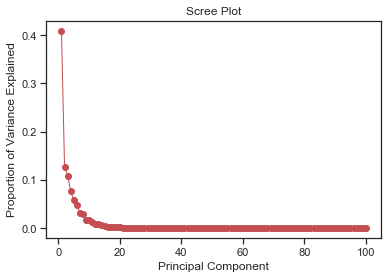

In [36]:
#Plot the Scree Plot
PC_values = np.arange(pca.n_components_)
PC_values = PC_values + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=1)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [37]:
# Read the proportion of variance explained based on the number of principle components
print ("Proportion of Variance Explained : ", pca.explained_variance_ratio_)      
out_sum = np.cumsum(pca.explained_variance_ratio_)  
print ("Cumulative Prop. Variance Explained: ", out_sum)

Proportion of Variance Explained :  [4.09331024e-01 1.27851501e-01 1.08867429e-01 7.75006860e-02
 5.77488877e-02 4.80315723e-02 3.21067236e-02 2.90256720e-02
 1.73599031e-02 1.67494752e-02 1.23195881e-02 9.53075849e-03
 8.05575866e-03 6.60250103e-03 5.63024404e-03 3.79435695e-03
 3.30394204e-03 2.58761737e-03 2.46196683e-03 1.86793460e-03
 1.70042412e-03 1.54253759e-03 1.30698713e-03 1.23130053e-03
 1.10080617e-03 1.03679788e-03 9.58094432e-04 8.33766477e-04
 7.38857721e-04 6.65106112e-04 6.47483103e-04 6.10669784e-04
 5.64705813e-04 5.13599429e-04 4.67529142e-04 3.75598232e-04
 3.57159006e-04 3.21747531e-04 2.99930049e-04 2.68442120e-04
 2.56203290e-04 2.42695343e-04 2.15736029e-04 1.87269063e-04
 1.68294733e-04 1.44313992e-04 1.38117815e-04 1.33606969e-04
 1.27897772e-04 1.14966926e-04 1.07277032e-04 1.02872371e-04
 9.74907598e-05 9.44491621e-05 8.68190837e-05 7.87395184e-05
 7.04198028e-05 6.74042967e-05 6.47573979e-05 5.98376682e-05
 5.56129344e-05 5.42674352e-05 5.14627391e-05 5.0

**According to the knee of our scree plot the best dimensionality using the PCA subspace is four. This number of principal components explains about 72% of the variance cumulatively. With the fourth principal component, the cumulative proportion of the variance explained surpasses 70%, therefore we would consider to keep four principal components.**

## Pairs Plot

In [38]:
#Creating Word2Vec embedding of test set 
test_embed = model.wv[test_vocab]

In [39]:
#Apply PCA to test_embed
from sklearn.decomposition import PCA
pca_2 = PCA(n_components=None)
pca_results_2 = pca_2.fit_transform(test_embed)

In [40]:
# Look at the PCA for our test set
pca_results_2

array([[-8.52629066e-01, -9.38479379e-02, -1.67248264e-01, ...,
         5.01408149e-03,  8.43868358e-04,  4.09408880e-04],
       [ 3.96398574e-01,  2.20926329e-01,  1.16847754e+00, ...,
         8.02062626e-04,  1.21749879e-03, -1.93783920e-03],
       [-8.17982018e-01, -1.01269893e-01, -1.56185046e-01, ...,
        -2.65423418e-03,  3.19850491e-03,  1.01179874e-03],
       ...,
       [-7.68263876e-01, -1.42274246e-01, -2.02830628e-01, ...,
        -3.72612209e-04, -1.69412221e-03,  3.89606692e-03],
       [ 9.79639124e-03, -1.87613517e-01,  1.17138634e-02, ...,
        -3.07623693e-03, -9.28378082e-04,  6.15237607e-03],
       [-4.87889826e-01, -6.23561777e-02, -1.10955365e-01, ...,
         1.77604146e-03, -2.06038915e-03, -5.24686184e-04]], dtype=float32)

In [41]:
# First 4 pc in my projection matrix
pca_4pc = pd.DataFrame(pca_results_2[:,0:4])
pca_4pc.head()

0         1         2         3
0 -0.852629 -0.093848 -0.167248 -0.411157
1  0.396399  0.220926  1.168478 -0.431319
2 -0.817982 -0.101270 -0.156185 -0.407109
3  0.085752 -0.390989  1.589218  0.049529
4 -0.004250  0.109484  0.178475  0.072579

### Whole test set

In [42]:
#Plotting pairplot for the first four dimensionalities
n_components = 4
pca_3 = PCA(n_components=n_components)
pca_results_3 = pca_3.fit_transform(test_embed)

total_var = pca_3.explained_variance_ratio_.sum() * 100

labels = {str(i): f"PC {i+1}" for i in range(n_components)}

fig = px.scatter_matrix(
    pca_results_3,
    dimensions=range(n_components),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%'
)
fig.update_traces(diagonal_visible=True)
fig.show()

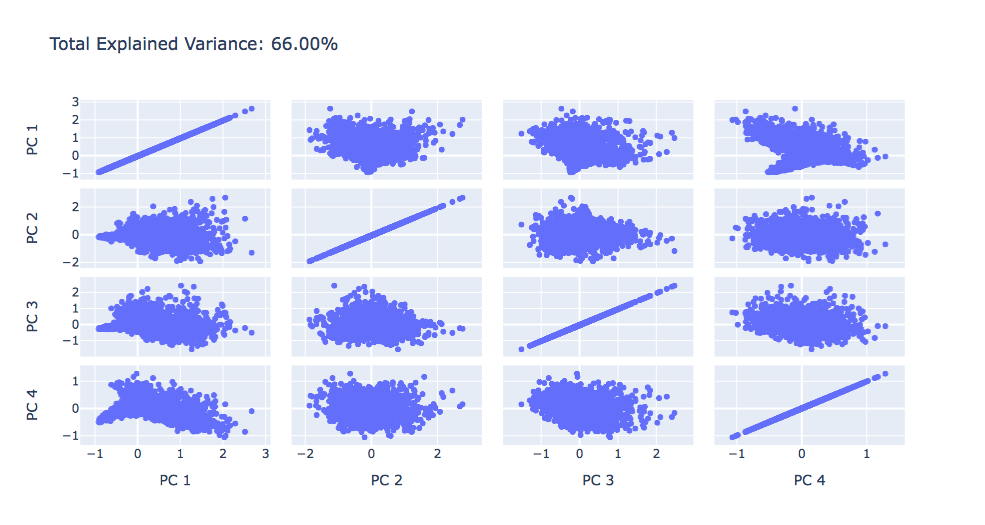

In [43]:
from PIL import Image
# Read image
img = Image.open('PCA_1.png')
img

**As can be seen from above the plots, PC1 always captures and explains the most variance of the data (41% as calculated in part 2). If we ignore PC1 and compare PC2 with the rest components, then PC2 becomes the first component and captures/explains the most variance of the data (13% as calculated in part 2), 10% for PC3 and 7% for PC4 respectively.\
The further we go from PC1, the less variance will be explanied by the component. So generally, we should select the top 4 or 5 components that explain the most variance. If we select all the components, it is just a rotation and is computationally expensive.**

### Sampled test set

**For better visualizing the data to analyze, we randomly draw a sample of 50 words from the test vocabulary. And iterate the above process again.**

In [44]:
# Sample list of words
import random
Sample_vocab = random.sample(test_vocab, 50)

In [45]:
#Creating Word2Vec embedding of test set 
Sample_embed = model.wv[Sample_vocab]
#Apply PCA to sample_embed
pca_sample = PCA(n_components=4)
pca_results_sample = pca_sample.fit_transform(Sample_embed)
pca_results_sample  = pd.DataFrame(pca_results_sample)
pca_results_sample["word"]= Sample_vocab
pca_results_sample["word"] = pca_results_sample["word"].astype('category',copy=False)
pca_results_sample

0         1         2         3           word
0   0.609556 -0.412296  0.129621  0.460024     phenomenon
1   0.857755 -0.916476  0.575804 -0.415108         future
2  -0.534025  0.208733 -0.287903 -0.038311    singularity
3  -0.648777  0.213358 -0.375454 -0.069718        suffers
4  -0.145515 -0.041838  0.526331  0.124419     divergence
5   0.143526  0.012636 -0.146842 -0.104715         differ
6  -0.342440 -0.010344 -0.219374 -0.086373            cbs
7  -0.158021 -0.647852  0.583233  0.009142       position
8  -0.739454  0.150717 -0.311691 -0.138070       suffices
9  -0.456710  0.136927 -0.195614 -0.036383            cub
10 -0.470340 -0.559141  1.409683 -0.104804         review
11 -0.674920  0.178539 -0.364132 -0.148754     multiproxy
12 -0.376799  0.008328  0.083883 -0.002559           mind
13  1.152309 -0.979703 -0.060823  0.067059         factor
14 -0.239182 -0.057439  0.120309  0.024233     litigation
15 -0.569551  0.160090 -0.283103 -0.091891   collectively
16 -0.047760 -0.073066 -0.233014 -0.064989     hydrologic
17  1.091913  1.170329  0.153382  1.487561           cold
18  0.161351  0.165705 -0.244073  0.319975         latent
19 -0.460109  0.043519 -0.001655 -0.026797    restricting
20 -0.250119 -0.007032 -0.085250  0.031336    contraction
21 -0.343982  0.044168 -0.083390 -0.049085            mlo
22  0.409142  0.635575  0.620780  0.346898       extended
23 -0.665217  0.154303 -0.369273 -0.150795           dull
24 -0.506044  0.044225  0.454455  0.130219        british
25 -0.251130 -0.071938  0.289734  0.055640  congressional
26  0.202846 -0.105950 -0.057522 -0.173610         depend
27 -0.638675  0.157117 -0.351815 -0.101724          spoke
28 -0.456848  0.081786 -0.169175 -0.023129          vague
29 -0.430819  0.115934 -0.148950 -0.036392            son
30  0.655065 -0.842652 -0.141611  0.004410     indirectly
31 -0.436796  0.078857 -0.125048 -0.092990         tariff
32 -0.207230 -0.084148 -0.065941 -0.033632   endangerment
33 -0.234333  0.178822  0.070152  0.008074           acre
34 -0.204795 -0.126337  0.144449  0.025349    distributed
35 -0.062170 -0.043089  0.262217  0.090661      existence
36  1.237628  0.012474 -0.755943  0.249235        content
37  0.774988 -0.638170 -0.493213  0.002185        thawing
38 -0.366704 -0.071612  0.150834  0.007080        promise
39  0.413941  0.386974 -0.028476  0.185463            die
40 -0.301039  0.046182  0.024506  0.131319    dehydration
41 -0.671615  0.141996 -0.374327 -0.142686          upset
42 -0.480628 -0.201495  0.638162 -0.000483      dedicated
43  1.831936  1.416378  0.411956 -1.235937        average
44 -0.380203  0.091768  0.118289  0.039094         oxford
45 -0.375044 -0.044003 -0.108890 -0.030918           fine
46  1.323735 -1.103432 -0.850786 -0.014520        release
47 -0.352949  0.123503 -0.049404  0.042248         flower
48  1.475963  0.031529  0.348773  0.036401          rapid
49  1.138288  0.847543 -0.133863 -0.463652         around

In [46]:
total_var = pca_sample.explained_variance_ratio_.sum() * 100

labels = {str(i): f"PC {i+1}" for i in range(n_components)}

fig = px.scatter_matrix(
    pca_results_sample,
    dimensions=range(n_components),
    labels=labels,
    color="word",
    title=f'Total Explained Variance: {total_var:.2f}%'
)
fig.update_traces(diagonal_visible=True)
fig.show()

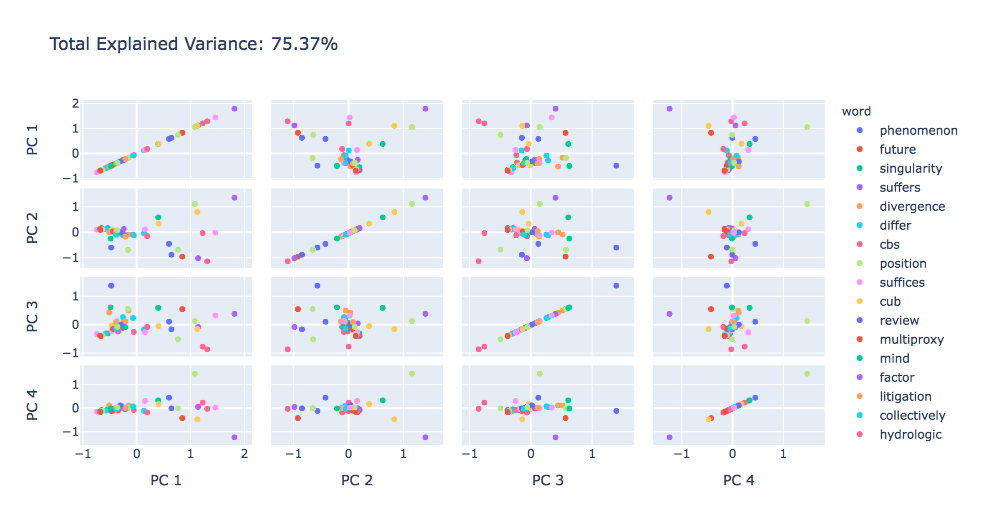

In [47]:
from PIL import Image
# Read image
img = Image.open('PCA_2.png')
img

**Based on a smaller scope, the PC1 still captures the most variance of the data (in the shape of a line in the above plots), while the points are more centered together in other components (in the shape of cloud in the above plots).\
For example, frequent and durable are in similar contexts - their PC1 varies (0.8 vs. -0.7) but for PC2 it is almost the same (around 0).**

## Compare the PCA Embeddings with Word2Vec Embeddings for PC=4

**First, after applying PCA on the test set, we use the whole test word2vec embedding to do the k-means clustering, and look at the cosine similarity within and between clusters. (k-means clustering, as an unsupervised machine learning algorithm, is a good way to find words in similar contexts. And the intention is that word embeddings in the same cluster should have higher cosine similarity than those in different clusters.)**

In [87]:
n_components = 4
pca_4 = PCA(n_components=n_components)
pca_results_4 = pca_4.fit_transform(test_embed)
pca_results_4  = pd.DataFrame(pca_results_4)
pca_results_4["word"]= test_vocab

In [88]:
pca_results_4

0         1         2         3           word
0    -0.866805 -0.058146 -0.165233 -0.420191    trenberth's
1     0.388431  0.344107  1.149538 -0.409926           view
2    -0.785353 -0.074851 -0.156450 -0.361147      clarified
3     0.069523 -0.171400  1.501320  0.038589          paper
4    -0.048084  0.143681  0.211874  0.084684     imperative
...        ...       ...       ...       ...            ...
4567 -0.784231 -0.098045 -0.167497 -0.251219        wishing
4568 -0.797746 -0.096804 -0.184683 -0.312540        river's
4569 -0.759976 -0.142939 -0.184714 -0.294311   deteriorated
4570  0.027396 -0.125747 -0.056522  0.203320  mediterranean
4571 -0.416608 -0.112777 -0.138836 -0.108731      monsoonal

[4572 rows x 5 columns]

In [89]:
df_clustering_2 = pca_results_4.drop('word',axis=1)

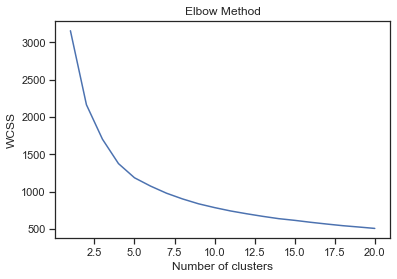

In [90]:
from sklearn.cluster import KMeans 
from scipy.spatial import distance

wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='random', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_clustering_2)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [91]:
kmeans = KMeans(n_clusters=5, init='random', max_iter=300, n_init=10, random_state=0)
kmeans.fit(df_clustering_2)

KMeans(init='random', n_clusters=5, random_state=0)

In [92]:
pca_results_4['label'] = kmeans.labels_
pca_results_4

0         1         2         3           word  label
0    -0.866805 -0.058146 -0.165233 -0.420191    trenberth's      0
1     0.388431  0.344107  1.149538 -0.409926           view      4
2    -0.785353 -0.074851 -0.156450 -0.361147      clarified      0
3     0.069523 -0.171400  1.501320  0.038589          paper      4
4    -0.048084  0.143681  0.211874  0.084684     imperative      2
...        ...       ...       ...       ...            ...    ...
4567 -0.784231 -0.098045 -0.167497 -0.251219        wishing      0
4568 -0.797746 -0.096804 -0.184683 -0.312540        river's      0
4569 -0.759976 -0.142939 -0.184714 -0.294311   deteriorated      0
4570  0.027396 -0.125747 -0.056522  0.203320  mediterranean      2
4571 -0.416608 -0.112777 -0.138836 -0.108731      monsoonal      0

[4572 rows x 6 columns]

In [93]:
pca_results_4.groupby('label').count()

0     1     2     3  word
label                              
0      1390  1390  1390  1390  1390
1       514   514   514   514   514
2      1923  1923  1923  1923  1923
3       359   359   359   359   359
4       386   386   386   386   386

In [94]:
pca_sample = pca_results_4.sample(n = 1000)

for k in [0,1,2,3,4]:
    pca_sub = pca_sample[pca_sample['label']==k].reset_index().drop('index',axis=1)
    similarity_score_list = []
    for i in range(len(pca_sub)):
        word_1 = pca_sub.iloc[i]['word']
        for j in range(i+1,len(pca_sub)):
            word_2 = pca_sub.iloc[j]['word']
            similarity_score_list.append(get_cosine_similarity(model.wv[word_1],model.wv[word_2]))
    similarity_mean = np.mean(similarity_score_list)
    print('in cluster'+' '+str(k)+', the average cosline similarity is'+' '+str(similarity_mean))

in cluster 0, the average cosline similarity is 0.964382
in cluster 1, the average cosline similarity is 0.7607337
in cluster 2, the average cosline similarity is 0.8946079
in cluster 3, the average cosline similarity is 0.7634286
in cluster 4, the average cosline similarity is 0.79081315


In [95]:
# due to the limitation of computational power, only compare cluster 1 and 2 as a between cluster case

pca_1 = pca_results_4[pca_results_4['label']==1].sample(n = 200).reset_index().drop('index',axis=1)
pca_2 = pca_results_4[pca_results_4['label']==2].sample(n = 200).reset_index().drop('index',axis=1)

similarity_score_list = []
for i in range(len(pca_1)):
    word_1 = pca_1.iloc[i]['word']
    for j in range(len(pca_2)):
        word_2 = pca_2.iloc[j]['word']
        similarity_score_list.append(get_cosine_similarity(model.wv[word_1],model.wv[word_2]))
similarity_mean = np.mean(similarity_score_list)
print('the average cosline similarity between cluster 0 and cluster 2 is'+' '+str(similarity_mean))

the average cosline similarity between cluster 0 and cluster 2 is 0.7255018


**We clustered them into 5 clusters based on Elbow method. As can be seen from the above, the best cosine similarity within clusters is 0.96 observed in cluster 0. However, when we compare word embeddings between clusters, the similarity is 0.72, which is much lower than 0.96. This is in accordance with our initial assumption, as words in one cluster are in similar contexts, leading to higher similarity score.\
The result is similar to the pre-PCA result, which means at a high level, the pattern and similarity of the data holds, and PCA captures the pattern of the data without losing too much information.**

In [151]:
Sample_vocab_sub = ['hurricane','typhoon','water','ocean','warming','temperature','land','increase','decrease',
                     'drop','better','worse','global','environment','scientist','research']
Sample_embed_sub = model.wv[Sample_vocab_sub]
pca_sample_sub = PCA(n_components=4)
pca_results_sample_sub = pca_sample_sub.fit_transform(Sample_embed_sub)
pca_results_sample_sub  = pd.DataFrame(pca_results_sample_sub)
pca_results_sample_sub["word"]= Sample_vocab_sub
pca_results_sample_sub["word"] = pca_results_sample_sub["word"].astype('category',copy=False)
pca_results_sample_sub

0         1         2         3         word
0   0.450543 -0.697590 -1.006720  0.198297    hurricane
1   0.396663 -0.469943 -0.525473  0.221668      typhoon
2  -1.198564 -0.969180 -0.246060 -0.312494        water
3  -1.509984 -0.450244  0.029222  0.477798        ocean
4   0.334288  1.021573  0.238828 -0.664801      warming
5  -0.452217  1.398728 -0.925751  0.169120  temperature
6  -0.754622 -0.039102  1.495895  1.125974         land
7  -0.715867  0.534424  0.252807 -0.834702     increase
8  -1.430534  0.154888 -0.006616 -0.276300     decrease
9  -0.539594  0.061035 -0.590549  0.206708         drop
10  0.671664 -0.648015 -0.173756  0.170383       better
11  0.266094 -0.459835  0.176858 -0.464756        worse
12  0.333115  1.043899  0.568391 -0.112094       global
13  1.081746 -1.095328  0.726937 -0.813605  environment
14  1.595389  0.387105  0.072843  0.209169    scientist
15  1.471879  0.227584 -0.086857  0.699634     research

In [152]:
one = pca_results_sample_sub[(pca_results_sample_sub['word']=='hurricane')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = pca_results_sample_sub[(pca_results_sample_sub['word']=='typhoon')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.9750577

In [153]:
one = pca_results_sample_sub[(pca_results_sample_sub['word']=='water')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = pca_results_sample_sub[(pca_results_sample_sub['word']=='ocean')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.79713714

In [154]:
one = pca_results_sample_sub[(pca_results_sample_sub['word']=='warming')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = pca_results_sample_sub[(pca_results_sample_sub['word']=='temperature')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.42057872

In [155]:
one = pca_results_sample_sub[(pca_results_sample_sub['word']=='water')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = pca_results_sample_sub[(pca_results_sample_sub['word']=='land')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.06920239

In [156]:
one = pca_results_sample_sub[(pca_results_sample_sub['word']=='increase')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = pca_results_sample_sub[(pca_results_sample_sub['word']=='decrease')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.73023623

In [157]:
one = pca_results_sample_sub[(pca_results_sample_sub['word']=='decrease')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = pca_results_sample_sub[(pca_results_sample_sub['word']=='drop')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.599861

In [158]:
one = pca_results_sample_sub[(pca_results_sample_sub['word']=='better')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = pca_results_sample_sub[(pca_results_sample_sub['word']=='worse')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.52259356

In [159]:
one = pca_results_sample_sub[(pca_results_sample_sub['word']=='global')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = pca_results_sample_sub[(pca_results_sample_sub['word']=='environment')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

-0.11915824

In [160]:
one = pca_results_sample_sub[(pca_results_sample_sub['word']=='scientist')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = pca_results_sample_sub[(pca_results_sample_sub['word']=='research')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.94382393

**As can be seen from the above, similarity score is lower for almost all pairs than the pre-PCA ones. This is in line with the fact that PCA only captures 4 dimensions and will loose some information about the data. However, the original trend still exists - words in similar contexts have higher similarity while words in dissimilar contexts have lower similarity, which means PCA captures the pattern of the data without losing too much information.**

# LLE

In [48]:
#Locally Linear Embedding (LLE)
from sklearn.manifold import LocallyLinearEmbedding as LLE
lle = LLE(n_components=4)
lle_results=lle.fit_transform(test_embed)
Result_LLE=pd.DataFrame(lle_results)
Result_LLE.head()

0         1         2         3
0 -0.089936  0.016833 -0.001353 -0.000526
1  0.001216 -0.006941 -0.010784  0.014899
2 -0.053543  0.023529 -0.001733 -0.000642
3  0.001216 -0.006991 -0.014393  0.038793
4  0.001214 -0.006955 -0.008930  0.007609

### Whole test set

In [49]:
#Plotting pairplot for the first four dimensionalities
n_components = 4
labels = {str(i): f"PC {i+1}" for i in range(n_components)}

fig = px.scatter_matrix(
   Result_LLE,
    dimensions=range(n_components),
    labels=labels
)
fig.update_traces(diagonal_visible=True)
fig.show()

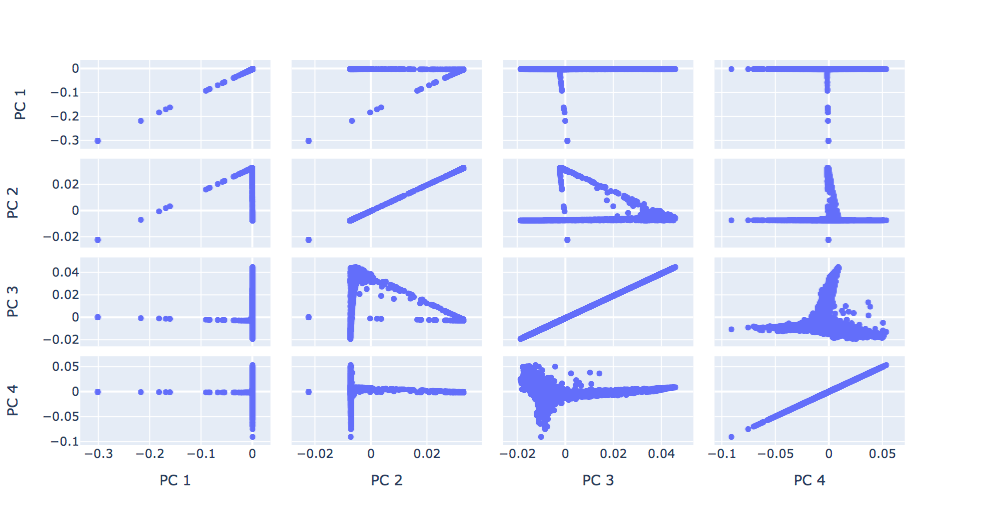

In [50]:
from PIL import Image
# Read image
img = Image.open('LLE_1.png')
img

**LLE, as a nonlinear method, reduces the data into lower dimensions and also retains the original relationship between data points. (From the plots, the data points are not clustered together like PCA, but in two vertical lines.) Besides, variances in different directions are the same.\
Technically, we should get mean of 0, which might not be the case in our plots. This can be resulted from the use of test set only.**

### Sampled test set

In [51]:
#Creating Word2Vec embedding of test set 
Sample_embed = model.wv[Sample_vocab]
#Apply PCA to sample_embed
lle = LLE(n_components=4)
lle_results_sample=lle.fit_transform(Sample_embed)
lle_results_sample = pd.DataFrame(lle_results_sample)
lle_results_sample["word"]= Sample_vocab
lle_results_sample["word"] = lle_results_sample["word"].astype('category',copy=False)
lle_results_sample

0         1         2         3           word
0   0.100009 -0.171976 -0.245051 -0.119587     phenomenon
1   0.101191 -0.139806  0.024894  0.071464         future
2  -0.083596  0.042425  0.172074 -0.494332    singularity
3  -0.320754 -0.054931 -0.009867 -0.006004        suffers
4   0.081556  0.074433 -0.160854  0.066687     divergence
5   0.066957  0.146740  0.134281  0.190268         differ
6  -0.168860  0.007477 -0.001841  0.075395            cbs
7   0.072001  0.070613 -0.185199  0.026992       position
8  -0.326805 -0.058224 -0.044613  0.113163       suffices
9  -0.053992  0.053208  0.145807 -0.380597            cub
10  0.043405  0.033737 -0.331812 -0.119657         review
11 -0.321780 -0.055348 -0.010875 -0.004315     multiproxy
12  0.047278  0.085847  0.027033 -0.065928           mind
13  0.119280 -0.352133 -0.351979 -0.229083         factor
14  0.066138  0.096777  0.021400  0.025490     litigation
15 -0.326778 -0.058513 -0.054444  0.150091   collectively
16  0.065303  0.121862  0.083138  0.174583     hydrologic
17  0.088939 -0.043791  0.032457  0.122334           cold
18  0.067889  0.081943  0.082871  0.135101         latent
19  0.023975  0.082493  0.069884 -0.113414    restricting
20  0.049391  0.114560  0.095450 -0.015610    contraction
21  0.022908  0.086955  0.093464 -0.135814            mlo
22  0.082320  0.052113 -0.098366  0.082901       extended
23 -0.327732 -0.058744 -0.050416  0.133199           dull
24  0.057698  0.067772 -0.176728 -0.016743        british
25  0.080320  0.080241 -0.161044  0.082892  congressional
26  0.072840  0.121746  0.041053  0.136052         depend
27 -0.327753 -0.058917 -0.055854  0.153579          spoke
28 -0.074295  0.044157  0.098631 -0.225905          vague
29  0.005922  0.073939  0.094015 -0.171847            son
30  0.102535 -0.176465 -0.238734 -0.108557     indirectly
31 -0.027928  0.062758  0.099587 -0.205369         tariff
32  0.055250  0.122463  0.102991  0.022973   endangerment
33  0.049355  0.082295  0.000937 -0.047554           acre
34  0.084755  0.088823 -0.121095  0.122209    distributed
35  0.077929  0.083112 -0.066589  0.054869      existence
36  0.097006 -0.221500  0.202613  0.102004        content
37  0.107520 -0.263675  0.188939  0.088451        thawing
38  0.061056  0.086848 -0.049049  0.006797        promise
39  0.069210  0.089638  0.076719  0.136357            die
40  0.052416  0.084206  0.060286 -0.029054    dehydration
41 -0.319559 -0.054153  0.001331 -0.045913          upset
42  0.078323  0.054383 -0.348677  0.062342      dedicated
43  0.083696 -0.033406  0.148443  0.143642        average
44  0.040935  0.086518  0.048727 -0.070774         oxford
45  0.042491  0.102682  0.100366 -0.033799           fine
46  0.134879 -0.560939  0.278095  0.038799        release
47  0.038004  0.080564  0.072397 -0.102014         flower
48  0.118876 -0.308063  0.050920  0.059474          rapid
49  0.070277  0.107258  0.114284  0.163764         around

In [52]:
#Plotting pairplot for the first four dimensionalities
n_components = 4
labels = {str(i): f"PC {i+1}" for i in range(n_components)}

fig = px.scatter_matrix(
   lle_results_sample,
    dimensions=range(n_components),
    labels=labels,
    color="word"
)
fig.update_traces(diagonal_visible=True)
fig.show()

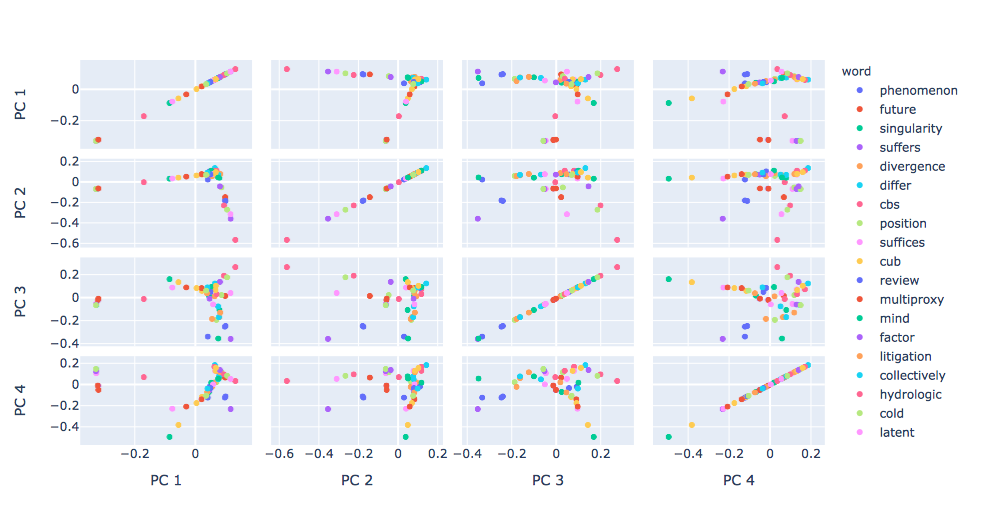

In [53]:
from PIL import Image
# Read image
img = Image.open('LLE_2.png')
img

**Based on a smaller scope, the explanations above still hold. Also, the mean is near 0 and variances in different directions are equal (take PC1 vs PC4 as an example).**

In [108]:
Result_LLE["word"]= test_vocab
Result_LLE

0         1         2         3           word
0     0.032628  0.005912  0.000108  0.000033    trenberth's
1    -0.007695  0.006434 -0.001539  0.005712           view
2     0.032591  0.005772 -0.000030 -0.000179      clarified
3    -0.007804  0.007497  0.004033  0.009918          paper
4    -0.007689  0.006098  0.002300  0.002838     imperative
...        ...       ...       ...       ...            ...
4567  0.032519  0.005520 -0.000019 -0.000120        wishing
4568  0.032581  0.005732  0.000013 -0.000095        river's
4569  0.032539  0.005592  0.000089  0.000061   deteriorated
4570 -0.007518  0.004447  0.001661 -0.000592  mediterranean
4571 -0.000157 -0.040766 -0.000035  0.000613      monsoonal

[4572 rows x 5 columns]

In [109]:
df_clustering_3 = Result_LLE.drop('word',axis=1)

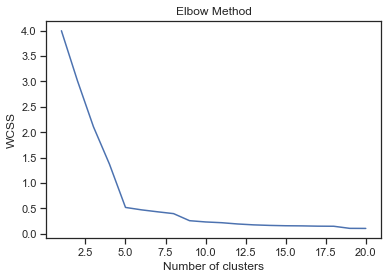

In [110]:
from sklearn.cluster import KMeans 
from scipy.spatial import distance

wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='random', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_clustering_3)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [117]:
kmeans = KMeans(n_clusters=5, init='random', max_iter=300, n_init=10, random_state=0)
kmeans.fit(df_clustering_3)

KMeans(init='random', n_clusters=5, random_state=0)

In [118]:
Result_LLE['label'] = kmeans.labels_
Result_LLE

0         1         2         3           word  label
0     0.032628  0.005912  0.000108  0.000033    trenberth's      0
1    -0.007695  0.006434 -0.001539  0.005712           view      2
2     0.032591  0.005772 -0.000030 -0.000179      clarified      0
3    -0.007804  0.007497  0.004033  0.009918          paper      2
4    -0.007689  0.006098  0.002300  0.002838     imperative      2
...        ...       ...       ...       ...            ...    ...
4567  0.032519  0.005520 -0.000019 -0.000120        wishing      0
4568  0.032581  0.005732  0.000013 -0.000095        river's      0
4569  0.032539  0.005592  0.000089  0.000061   deteriorated      0
4570 -0.007518  0.004447  0.001661 -0.000592  mediterranean      2
4571 -0.000157 -0.040766 -0.000035  0.000613      monsoonal      1

[4572 rows x 6 columns]

In [119]:
Result_LLE.groupby(['label']).count()

0     1     2     3  word
label                              
0       783   783   783   783   783
1       505   505   505   505   505
2      3245  3245  3245  3245  3245
3         3     3     3     3     3
4        36    36    36    36    36

In [120]:
lle_sample = Result_LLE.sample(n = 1000)

for k in [0,1,2,3,4]:
    lle_sub = lle_sample[lle_sample['label']==k].reset_index().drop('index',axis=1)
    similarity_score_list = []
    for i in range(len(lle_sub)):
        word_1 = lle_sub.iloc[i]['word']
        for j in range(i+1,len(lle_sub)):
            word_2 = lle_sub.iloc[j]['word']
            similarity_score_list.append(get_cosine_similarity(model.wv[word_1],model.wv[word_2]))
    similarity_mean = np.mean(similarity_score_list)
    print('in cluster'+' '+str(k)+', the average cosline similarity is'+' '+str(similarity_mean))

in cluster 0, the average cosline similarity is 0.9646948
in cluster 1, the average cosline similarity is 0.96417177
in cluster 2, the average cosline similarity is 0.79045665
in cluster 3, the average cosline similarity is nan
in cluster 4, the average cosline similarity is 0.812028


/Library/Anaconda/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning:

Mean of empty slice.

/Library/Anaconda/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



In [121]:
# due to the limitation of computational power, only compare cluster 1 and 2 as a between cluster case

lle_1 = Result_LLE[Result_LLE['label']==1].sample(n = 200).reset_index().drop('index',axis=1)
lle_2 = Result_LLE[Result_LLE['label']==2].sample(n = 200).reset_index().drop('index',axis=1)

similarity_score_list = []
for i in range(len(lle_1)):
    word_1 = lle_1.iloc[i]['word']
    for j in range(len(lle_2)):
        word_2 = lle_2.iloc[j]['word']
        similarity_score_list.append(get_cosine_similarity(model.wv[word_1],model.wv[word_2]))
similarity_mean = np.mean(similarity_score_list)
print('the average cosline similarity between cluster 1 and cluster 2 is'+' '+str(similarity_mean))

the average cosline similarity between cluster 1 and cluster 2 is 0.85355383


**We clustered them into 5 clusters based on Elbow method. As can be seen from the above, the best cosine similarity within clusters is 0.96 observed in cluster 0 and 1. The overall average cosine similarity within clusters is 0.88, which is a higher score compared with the linear PCA. When we compare word embeddings between clusters, the similarity is 0.85, which means LLE does not separate those dissimilar words well compared with PCA.**

In [204]:
Sample_vocab_sub = ['hurricane','typhoon','water','ocean','warming','temperature','land','increase','decrease',
                     'drop','better','worse','global','environment','scientist','research']
Sample_embed_sub = model.wv[Sample_vocab_sub]
lle_sub = LLE(n_components=4)
lle_results_sample_sub=lle.fit_transform(Sample_embed_sub)
lle_results_sample_sub = pd.DataFrame(lle_results_sample_sub)
lle_results_sample_sub["word"]= Sample_vocab_sub
lle_results_sample_sub["word"] = lle_results_sample_sub["word"].astype('category',copy=False)
lle_results_sample_sub

0         1         2         3         word
0   0.140583  0.448746 -0.349620 -0.407544    hurricane
1   0.185696  0.317925 -0.243043 -0.039172      typhoon
2  -0.245460  0.038569 -0.026996  0.321310        water
3  -0.278504  0.137840  0.033502  0.438085        ocean
4  -0.036186 -0.235629  0.232228 -0.345213      warming
5  -0.167101  0.111234  0.191077 -0.259045  temperature
6  -0.175218 -0.087488 -0.111653  0.153976         land
7  -0.309484 -0.207110  0.087975 -0.224765     increase
8  -0.366818  0.062348  0.127966  0.177732     decrease
9  -0.115418  0.321431 -0.014004 -0.047529         drop
10  0.298668  0.050556 -0.251467  0.233086       better
11  0.016487 -0.235191 -0.325493 -0.118927        worse
12  0.037249 -0.077507  0.309539 -0.234885       global
13  0.147652 -0.613742 -0.393967  0.064827  environment
14  0.347042 -0.087916  0.373108 -0.047707    scientist
15  0.520812  0.055935  0.360849  0.335771     research

In [169]:
one = lle_results_sample_sub[(lle_results_sample_sub['word']=='hurricane')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = lle_results_sample_sub[(lle_results_sample_sub['word']=='typhoon')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.8531631505828314

In [170]:
one = lle_results_sample_sub[(lle_results_sample_sub['word']=='water')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = lle_results_sample_sub[(lle_results_sample_sub['word']=='ocean')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.9747529713935994

In [171]:
one = lle_results_sample_sub[(lle_results_sample_sub['word']=='warming')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = lle_results_sample_sub[(lle_results_sample_sub['word']=='temperature')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.6246972577921373

In [172]:
one = lle_results_sample_sub[(lle_results_sample_sub['word']=='water')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = lle_results_sample_sub[(lle_results_sample_sub['word']=='land')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.8289540020627097

In [173]:
one = lle_results_sample_sub[(lle_results_sample_sub['word']=='increase')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = lle_results_sample_sub[(lle_results_sample_sub['word']=='decrease')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.3753781774546351

In [174]:
one = lle_results_sample_sub[(lle_results_sample_sub['word']=='decrease')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = lle_results_sample_sub[(lle_results_sample_sub['word']=='drop')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.34992884251024814

In [175]:
one = lle_results_sample_sub[(lle_results_sample_sub['word']=='better')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = lle_results_sample_sub[(lle_results_sample_sub['word']=='worse')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.24595310926157285

In [176]:
one = lle_results_sample_sub[(lle_results_sample_sub['word']=='global')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = lle_results_sample_sub[(lle_results_sample_sub['word']=='environment')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

-0.28294364922432425

In [177]:
one = lle_results_sample_sub[(lle_results_sample_sub['word']=='scientist')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = lle_results_sample_sub[(lle_results_sample_sub['word']=='research')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.7883443533881671

**As can be seen from the above, the original relationship of the similarity changes. For example, 1) water and land are two words in different contexts, but they get high similarity score; 2) decrease and drop are similar but get low similarity socre. This means that for the climate_fever dataset, linear methods such as PCA works better than LLE, which is a non-linear method.\
Besides, for similar words 'scientist' and 'research', the similarity scores in PCA and word2vec are higher than that in LLE, which means LLE is not a good method for this dataset.**

# t-SNE

**SNE and t-SNE are usually used for data visualization so we usually have h = 2. When using the original t-SNE the subspace (embedding space) is two dimensional.**

In [127]:
# T-SNE (t-distributed Stochastic Neighbor Embedding)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(test_embed)

### Whole test set

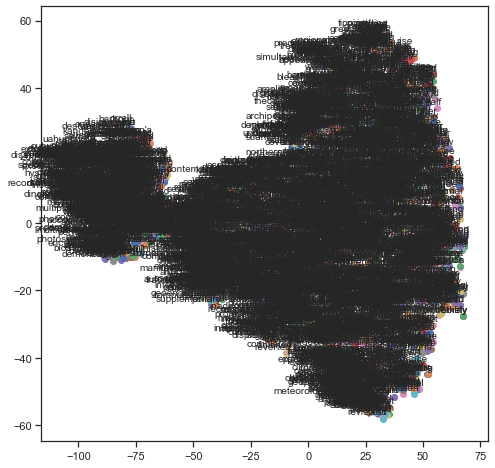

In [128]:
# define the function to produce the biplot  
x = []  
y = []  
for value in tsne_results:  
    x.append(value[0])  
    y.append(value[1])  

plt.figure(figsize=(8, 8))   
for i in range(len(x)):  
    plt.scatter(x[i],y[i])  
    plt.annotate(test_vocab[i],  
    xy=(x[i], y[i]),  
    xytext=(5, 2),  
    textcoords='offset points',  
    ha='right',  
    va='bottom')  

**As can be seen from the plot, there is a pattern that words in similar contexts tend to appear in the same cluster.\
Since we have so many words overlapping and cannot get further information from this plot, we sample the data and plot them in a separate figure.**

### Sampled test set

In [217]:
Sample_word_list = ['fossil','fuel','burning','deforestation','combustion','clearing','agriculture','production',\
                   'greenland','ice','decline','collapse','shrinkage','glacier','warming','snowfall','rain',\
                   'plant','sunlight','flowering','alert','typhoon','hurricane','decrease','tree','ocean',\
                   'water','better','worse','research','scientist','seven','twelve']
Sample_embed_new = model.wv[Sample_word_list]

In [218]:
# T-SNE (t-distributed Stochastic Neighbor Embedding)
from sklearn.manifold import TSNE
tsne_sample = TSNE(n_components=2, random_state=0)
tsne_results_sample = tsne_sample.fit_transform(Sample_embed_new)

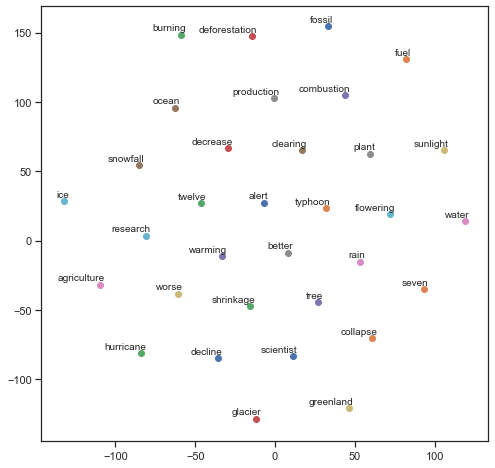

In [220]:
# define the function to produce the biplot for the sampled test set 
x = []  
y = []  
for value in tsne_results_sample:  
    x.append(value[0])  
    y.append(value[1])  

plt.figure(figsize=(8, 8))   
for i in range(len(Sample_word_list)):  
    plt.scatter(x[i],y[i])  
    plt.annotate(Sample_word_list[i],  
    xy=(x[i], y[i]),  
    xytext=(5, 2),  
    textcoords='offset points',  
    ha='right',  
    va='bottom')  

**From the above, we can summarize that overall, words in similar contexts are close to each other. For example, we can get several typical cluster: (ice, snowfall, ocean), (water, rain, flowering, plant, sunlight, typhoon), (shrinkage, decline), (fossil, fuel, combustion, deforestation, burning).**

In [131]:
Result_tsne=pd.DataFrame(tsne_results)
Result_tsne["word"]= test_vocab
Result_tsne

0          1           word
0    -105.300598  18.428171    trenberth's
1      46.778690 -43.868198           view
2     -98.969521  11.101699      clarified
3      34.346725 -56.563187          paper
4      22.759722  -4.560979     imperative
...          ...        ...            ...
4567  -94.444069   1.509597        wishing
4568 -100.176521   8.555578        river's
4569  -89.187256  16.206213   deteriorated
4570    0.220979  16.530670  mediterranean
4571  -38.967140   5.687366      monsoonal

[4572 rows x 3 columns]

In [132]:
df_clustering_4 = Result_tsne.drop('word',axis=1)

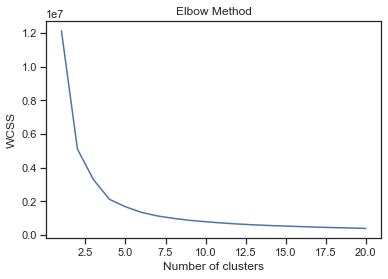

In [133]:
from sklearn.cluster import KMeans 
from scipy.spatial import distance

wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='random', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_clustering_4)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [134]:
kmeans = KMeans(n_clusters=5, init='random', max_iter=300, n_init=10, random_state=0)
kmeans.fit(df_clustering_4)

KMeans(init='random', n_clusters=5, random_state=0)

In [135]:
Result_tsne['label'] = kmeans.labels_
Result_tsne

0          1           word  label
0    -105.300598  18.428171    trenberth's      2
1      46.778690 -43.868198           view      4
2     -98.969521  11.101699      clarified      2
3      34.346725 -56.563187          paper      4
4      22.759722  -4.560979     imperative      1
...          ...        ...            ...    ...
4567  -94.444069   1.509597        wishing      2
4568 -100.176521   8.555578        river's      2
4569  -89.187256  16.206213   deteriorated      2
4570    0.220979  16.530670  mediterranean      3
4571  -38.967140   5.687366      monsoonal      0

[4572 rows x 4 columns]

In [136]:
Result_tsne.groupby(['label']).count()

0     1  word
label                  
0      1094  1094  1094
1       750   750   750
2       787   787   787
3       999   999   999
4       942   942   942

In [137]:
tsne_sample = Result_tsne.sample(n = 1000)

for k in [0,1,2,3,4]:
    tsne_sub = tsne_sample[tsne_sample['label']==k].reset_index().drop('index',axis=1)
    similarity_score_list = []
    for i in range(len(tsne_sub)):
        word_1 = tsne_sub.iloc[i]['word']
        for j in range(i+1,len(tsne_sub)):
            word_2 = tsne_sub.iloc[j]['word']
            similarity_score_list.append(get_cosine_similarity(model.wv[word_1],model.wv[word_2]))
    similarity_mean = np.mean(similarity_score_list)
    print('in cluster'+' '+str(k)+', the average cosline similarity is'+' '+str(similarity_mean))

in cluster 0, the average cosline similarity is 0.9601138
in cluster 1, the average cosline similarity is 0.7598175
in cluster 2, the average cosline similarity is 0.96685416
in cluster 3, the average cosline similarity is 0.8020152
in cluster 4, the average cosline similarity is 0.8565351


In [138]:
# due to the limitation of computational power, only compare cluster 2 and 3 as a between cluster case

tsne_2 = Result_tsne[Result_tsne['label']==2].sample(n = 200).reset_index().drop('index',axis=1)
tsne_3 = Result_tsne[Result_tsne['label']==3].sample(n = 200).reset_index().drop('index',axis=1)

similarity_score_list = []
for i in range(len(tsne_2)):
    word_1 = tsne_2.iloc[i]['word']
    for j in range(len(tsne_3)):
        word_2 = tsne_3.iloc[j]['word']
        similarity_score_list.append(get_cosine_similarity(model.wv[word_1],model.wv[word_2]))
similarity_mean = np.mean(similarity_score_list)
print('the average cosline similarity between cluster 2 and cluster 3 is'+' '+str(similarity_mean))

the average cosline similarity between cluster 2 and cluster 3 is 0.82385695


**We clustered them into 5 clusters based on Elbow method. As can be seen from the above, the best cosine similarity within clusters is 0.96 observed in cluster 0 and 2. The overall average cosine similarity within clusters is 0.86, which is a higher score compared with the linear PCA. When we compare word embeddings between clusters, the similarity is 0.82, which means t-SNE does not separate those dissimilar words well compared with PCA, but better than LLE.**

In [188]:
Sample_vocab_sub = ['hurricane','typhoon','water','ocean','warming','temperature','land','increase','decrease',
                     'drop','better','worse','global','environment','scientist','research']
Sample_embed_sub = model.wv[Sample_vocab_sub]
tsne_sub = TSNE(n_components=2, random_state=0)
tsne_results_sub = tsne_sub.fit_transform(Sample_embed_sub)
Result_tsne_frame_sub=pd.DataFrame(tsne_results_sub)
Result_tsne_frame_sub["word"]= Sample_vocab_sub
Result_tsne_frame_sub["word"] =Result_tsne_frame_sub["word"].astype('category',copy=False)
Result_tsne_frame_sub

0           1         word
0  -225.349854  113.708771    hurricane
1   -11.214129  210.724503      typhoon
2  -370.246948  298.926941        water
3  -115.863266  418.656219        ocean
4   -38.937935  -11.941959      warming
5  -468.892181   27.747469  temperature
6   394.578949  -27.335003         land
7   195.150314  102.077026     increase
8  -445.241516 -257.978210     decrease
9   -54.327461 -242.647034         drop
10 -219.093063 -421.854706       better
11  147.051407 -128.542709        worse
12 -249.556183 -122.286224       global
13  295.431061 -302.292206  environment
14  209.292816  347.965088    scientist
15   68.881561 -446.165314     research

In [189]:
one = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='hurricane')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='typhoon')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.49729484

In [190]:
one = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='water')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='ocean')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.81295717

In [191]:
one = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='warming')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='temperature')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.9370568

In [192]:
one = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='water')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='land')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

-0.8196171

In [193]:
one = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='increase')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='decrease')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

-0.9990666

In [194]:
one = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='decrease')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='drop')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.6782703

In [195]:
one = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='better')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='worse')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

0.23704872

In [196]:
one = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='global')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='environment')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

-0.3129451

In [197]:
one = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='scientist')]
one = one.drop(['word'], axis=1)
one = np.array(one)
two = Result_tsne_frame_sub[(Result_tsne_frame_sub['word']=='research')]
two = two.drop(['word'], axis=1)
two = np.array(two)
get_cosine_similarity(one,two)

-0.7682581

**As can be seen from the above, t-SNE is a better dimensionality reduction method to find similar/dissimilar words than LLE, but worse than linear PCA for our dataset. (Based on the results we get through CM2 till CM4)
For example, similarity score for 'increase' and 'decrease' is almost 1 in t-SNE, which means it does better than both PCA and LLE. But overall, the linear PCA still does better (for 'scientist' and 'reserach', the score in PCA is 0.94, but around 0.75-0.80 in LLE and t-SNE).\
To sum up, for climate_fever dataset, linear method such as PCA is a better way to do dimensionality reduction than non-linear methods such as LLE and t-SNE.**